# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [23]:
from pathlib import Path

import yaml
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt
import pandas as pd

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_well_metadata, nd2_to_tiff_well
from lib.preprocess.file_utils import get_sample_fps

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "brieflow_output/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile, "cycle""` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phentoype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern (path and sample) should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- For both path and sample patterns, numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample fil epath should have an associated plate/well. For single plate/well screens manually add a plate/well to the file path dataframe.

In [12]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# Directory, pattern, and metadata for SBS sample nd2 files
SBS_IMAGES_DIR_FP = Path("/archive/cheeseman/brieflow_screens/baker/input_sbs/")
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/\d+_\d+_\d+/Well([A-Z]\d+)_Channel([A-Za-z0-9_-]+)_Seq\d+\.nd2"
SBS_PATH_METADATA = ["plate", "cycle", "well", "channel"]
SBS_METADATA_ORDER_TYPE = {
    "plate": int,
    "well": str,
    "cycle": int,
    "channel": str
}

# Directory, pattern, and metadata for phenotype sample nd2 files
PHENOTYPE_IMAGES_DIR_FP = Path("/archive/cheeseman/brieflow_screens/baker/input_ph/")
PHENOTYPE_PATH_PATTERN = r"plate_(\d+)/round_(\d+)/Well([A-Z]\d+)_Channel((?:DAPI_1x1|GFP_1x1|A594_1x1|A750_1x1))_LF_Seq\d+\.nd2"
PHENOTYPE_PATH_METADATA = ["plate", "round", "well", "channel"]
PHENOTYPE_METADATA_ORDER_TYPE = {
    "plate": int,
    "well": str,
    "round": int,
    "channel": str
}

You must supply a working regex to the `SBS_PATH_PATTERN` and `PHENOTYPE_PATH_PATTERN` variables. If you don't have experience with regex, you can use the following LLM prompt to generate the patterns.

*Enter into a basic LLM chatbot*: 

Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example sbs filenames: **[ENTER YOUR EXAMPLE SBS FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Example phenotype filenames: **[ENTER YOUR EXAMPLE PHENOTYPE FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Required regex patterns (return these exact variable assignments):
```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:
1. SBS pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - Cycle number (after "/c")
2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

Also provide the corresponding metadata lists and variable types:
```python
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"

SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]

SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

## Create Sample DFs

In [13]:
sbs_samples = create_samples_df(
    SBS_IMAGES_DIR_FP, SBS_PATH_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE
)
# Save and display sample dataframe
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create sample dataframe for phenotype
phenotype_samples = create_samples_df(
    PHENOTYPE_IMAGES_DIR_FP,
    PHENOTYPE_PATH_PATTERN,
    PHENOTYPE_PATH_METADATA,
    PHENOTYPE_METADATA_ORDER_TYPE,
)
# Save and display sample dataframe
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

SBS samples:


sample_fp  plate well  cycle  \
0    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      1   
1    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
2    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
3    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
4    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
..                                                 ...    ...  ...    ...   
193  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      8   
194  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   
195  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   
196  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   
197  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   

                                          channel  
0    Dapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p  
1                                        A594_30p  
2                                     CY3_30p_545  
3                                         CY5_30p  
4                                         CY7_30p  
..                                            ...  
193                                       CY7_30p  
194                                      A594_30p  
195                                   CY3_30p_545  
196                                       CY5_30p  
197                                       CY7_30p  

[198 rows x 5 columns]

Phenotype samples:


sample_fp  plate well  round  \
0   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      1   
1   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      1   
2   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      1   
3   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      1   
4   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A2      1   
5   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A2      1   
6   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A2      1   
7   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A2      1   
8   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A3      1   
9   /archive/cheeseman/brieflow_screens/baker/inpu...      1   A3      1   
10  /archive/cheeseman/brieflow_screens/baker/inpu...      1   A3      1   
11  /archive/cheeseman/brieflow_screens/baker/inpu...      1   A3      1   
12  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B1      1   
13  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B1      1   
14  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B1      1   
15  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B1      1   
16  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B2      1   
17  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B2      1   
18  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B2      1   
19  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B2      1   
20  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      1   
21  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      1   
22  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      1   
23  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      1   

     channel  
0   A594_1x1  
1   A750_1x1  
2   DAPI_1x1  
3    GFP_1x1  
4   A594_1x1  
5   A750_1x1  
6   DAPI_1x1  
7    GFP_1x1  
8   A594_1x1  
9   A750_1x1  
10  DAPI_1x1  
11   GFP_1x1  
12  A594_1x1  
13  A750_1x1  
14  DAPI_1x1  
15   GFP_1x1  
16  A594_1x1  
17  A750_1x1  
18  DAPI_1x1  
19   GFP_1x1  
20  A594_1x1  
21  A750_1x1  
22  DAPI_1x1  
23   GFP_1x1

## Test Metadata Extraction

In [14]:
if SBS_IMAGES_DIR_FP is not None:
    # Extract metadata from test sbs sample
    test_sbs_metadata = extract_well_metadata(
        sbs_samples["sample_fp"][0],
        sbs_samples["plate"][0],
        sbs_samples["well"][0],
        verbose=True,
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Extract metadata from test phenotype sample
    test_phenotype_metadata = extract_well_metadata(
        phenotype_samples["sample_fp"][0],
        phenotype_samples["plate"][0],
        phenotype_samples["well"][0],
        verbose=True,
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Processing well file: /archive/cheeseman/brieflow_screens/baker/input_sbs/plate_1/c1/20220630_124506_255/WellA1_ChannelDapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p_Seq0000.nd2
File shape: (333, 5, 1480, 1480)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'P': 333, 'C': 5, 'Y': 1480, 'X': 1480}
Number of positions: 333
Number of Z planes: 1
SBS test metadata:


x_pos    y_pos    z_pos pfs_offset  plate well  tile cycle  \
0    41882.4 -35844.4  2911.24       None      1   A1     0  None   
1    40355.0 -35844.9  2913.70       None      1   A1     1  None   
2    38827.4 -35844.8  2914.06       None      1   A1     2  None   
3    37299.7 -35844.7  2916.90       None      1   A1     3  None   
4    35772.3 -35844.7  2918.50       None      1   A1     4  None   
..       ...      ...      ...        ...    ...  ...   ...   ...   
328  41882.4  -5293.0  2898.98       None      1   A1   328  None   
329  40355.1  -5293.3  2899.00       None      1   A1   329  None   
330  38827.6  -5293.3  2899.00       None      1   A1   330  None   
331  37299.7  -5293.2  2899.08       None      1   A1   331  None   
332  35772.3  -5293.2  2899.00       None      1   A1   332  None   

                                              filename  channels  \
0    /archive/cheeseman/brieflow_screens/baker/inpu...         5   
1    /archive/cheeseman/brieflow_screens/baker/inpu...         5   
2    /archive/cheeseman/brieflow_screens/baker/inpu...         5   
3    /archive/cheeseman/brieflow_screens/baker/inpu...         5   
4    /archive/cheeseman/brieflow_screens/baker/inpu...         5   
..                                                 ...       ...   
328  /archive/cheeseman/brieflow_screens/baker/inpu...         5   
329  /archive/cheeseman/brieflow_screens/baker/inpu...         5   
330  /archive/cheeseman/brieflow_screens/baker/inpu...         5   
331  /archive/cheeseman/brieflow_screens/baker/inpu...         5   
332  /archive/cheeseman/brieflow_screens/baker/inpu...         5   

     pixel_size_x  pixel_size_y  
0        1.214286      1.214286  
1        1.214286      1.214286  
2        1.214286      1.214286  
3        1.214286      1.214286  
4        1.214286      1.214286  
..            ...           ...  
328      1.214286      1.214286  
329      1.214286      1.214286  
330      1.214286      1.214286  
331      1.214286      1.214286  
332      1.214286      1.214286  

[333 rows x 12 columns]

Processing well file: /archive/cheeseman/brieflow_screens/baker/input_ph/plate_1/round_1/WellA1_ChannelA594_1x1_LF_Seq0001.nd2
File shape: (1281, 4, 2960, 2960)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Number of positions: 1281
Number of Z planes: 4
Phenotype test metadata:


x_pos    y_pos    z_pos pfs_offset  plate well  tile cycle  \
0     41100.5 -35853.2  2931.46       None      1   A1     0  None   
1     40336.7 -35853.2  2933.84       None      1   A1     1  None   
2     39572.8 -35853.2  2934.70       None      1   A1     2  None   
3     38809.2 -35853.3  2935.82       None      1   A1     3  None   
4     38045.3 -35853.3  2937.20       None      1   A1     4  None   
...       ...      ...      ...        ...    ...  ...   ...   ...   
1276  39572.7  -5301.9  2913.16       None      1   A1  1276  None   
1277  38809.4  -5301.9  2913.12       None      1   A1  1277  None   
1278  38045.3  -5301.9  2913.06       None      1   A1  1278  None   
1279  37281.8  -5301.9  2913.10       None      1   A1  1279  None   
1280  36517.9  -5301.9  2913.20       None      1   A1  1280  None   

                                               filename  channels  \
0     /archive/cheeseman/brieflow_screens/baker/inpu...         1   
1     /archive/cheeseman/brieflow_screens/baker/inpu...         1   
2     /archive/cheeseman/brieflow_screens/baker/inpu...         1   
3     /archive/cheeseman/brieflow_screens/baker/inpu...         1   
4     /archive/cheeseman/brieflow_screens/baker/inpu...         1   
...                                                 ...       ...   
1276  /archive/cheeseman/brieflow_screens/baker/inpu...         1   
1277  /archive/cheeseman/brieflow_screens/baker/inpu...         1   
1278  /archive/cheeseman/brieflow_screens/baker/inpu...         1   
1279  /archive/cheeseman/brieflow_screens/baker/inpu...         1   
1280  /archive/cheeseman/brieflow_screens/baker/inpu...         1   

      pixel_size_x  pixel_size_y  
0         0.303571      0.303571  
1         0.303571      0.303571  
2         0.303571      0.303571  
3         0.303571      0.303571  
4         0.303571      0.303571  
...            ...           ...  
1276      0.303571      0.303571  
1277      0.303571      0.303571  
1278      0.303571      0.303571  
1279      0.303571      0.303571  
1280      0.303571      0.303571  

[1281 rows x 12 columns]

## <font color='red'>SET PARAMETERS</font>

### ND2 conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [15]:
SBS_CHANNEL_ORDER = ["CY3_30p_545", "A594_30p", "CY5_30p", "CY7_30p"]
PHENOTYPE_CHANNEL_ORDER = ["DAPI_1x1", "GFP_1x1", "A594_1x1", "A750_1x1"]
PHENOTYPE_ROUND_ORDER = [1, 2]

In [16]:
SBS_CHANNEL_ORDER_FLIP = False
PHENOTYPE_CHANNEL_ORDER_FLIP = False

## Test ND2 Conversion

### Test SBS conversion

In [17]:
sbs_samples

sample_fp  plate well  cycle  \
0    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      1   
1    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
2    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
3    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
4    /archive/cheeseman/brieflow_screens/baker/inpu...      1   A1      2   
..                                                 ...    ...  ...    ...   
193  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      8   
194  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   
195  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   
196  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   
197  /archive/cheeseman/brieflow_screens/baker/inpu...      1   B3      9   

                                          channel  
0    Dapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p  
1                                        A594_30p  
2                                     CY3_30p_545  
3                                         CY5_30p  
4                                         CY7_30p  
..                                            ...  
193                                       CY7_30p  
194                                      A594_30p  
195                                   CY3_30p_545  
196                                       CY5_30p  
197                                       CY7_30p  

[198 rows x 5 columns]


Processing file: /archive/cheeseman/brieflow_screens/baker/input_sbs/plate_1/c1/20220630_124506_255/WellA1_ChannelDapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p_Seq0000.nd2
File dimensions: {'P': 333, 'C': 5, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (5, 1480, 1480)
Final dimensions (CYX): (5, 1480, 1480)
Array size in bytes: 21904000
Converted SBS test sample:


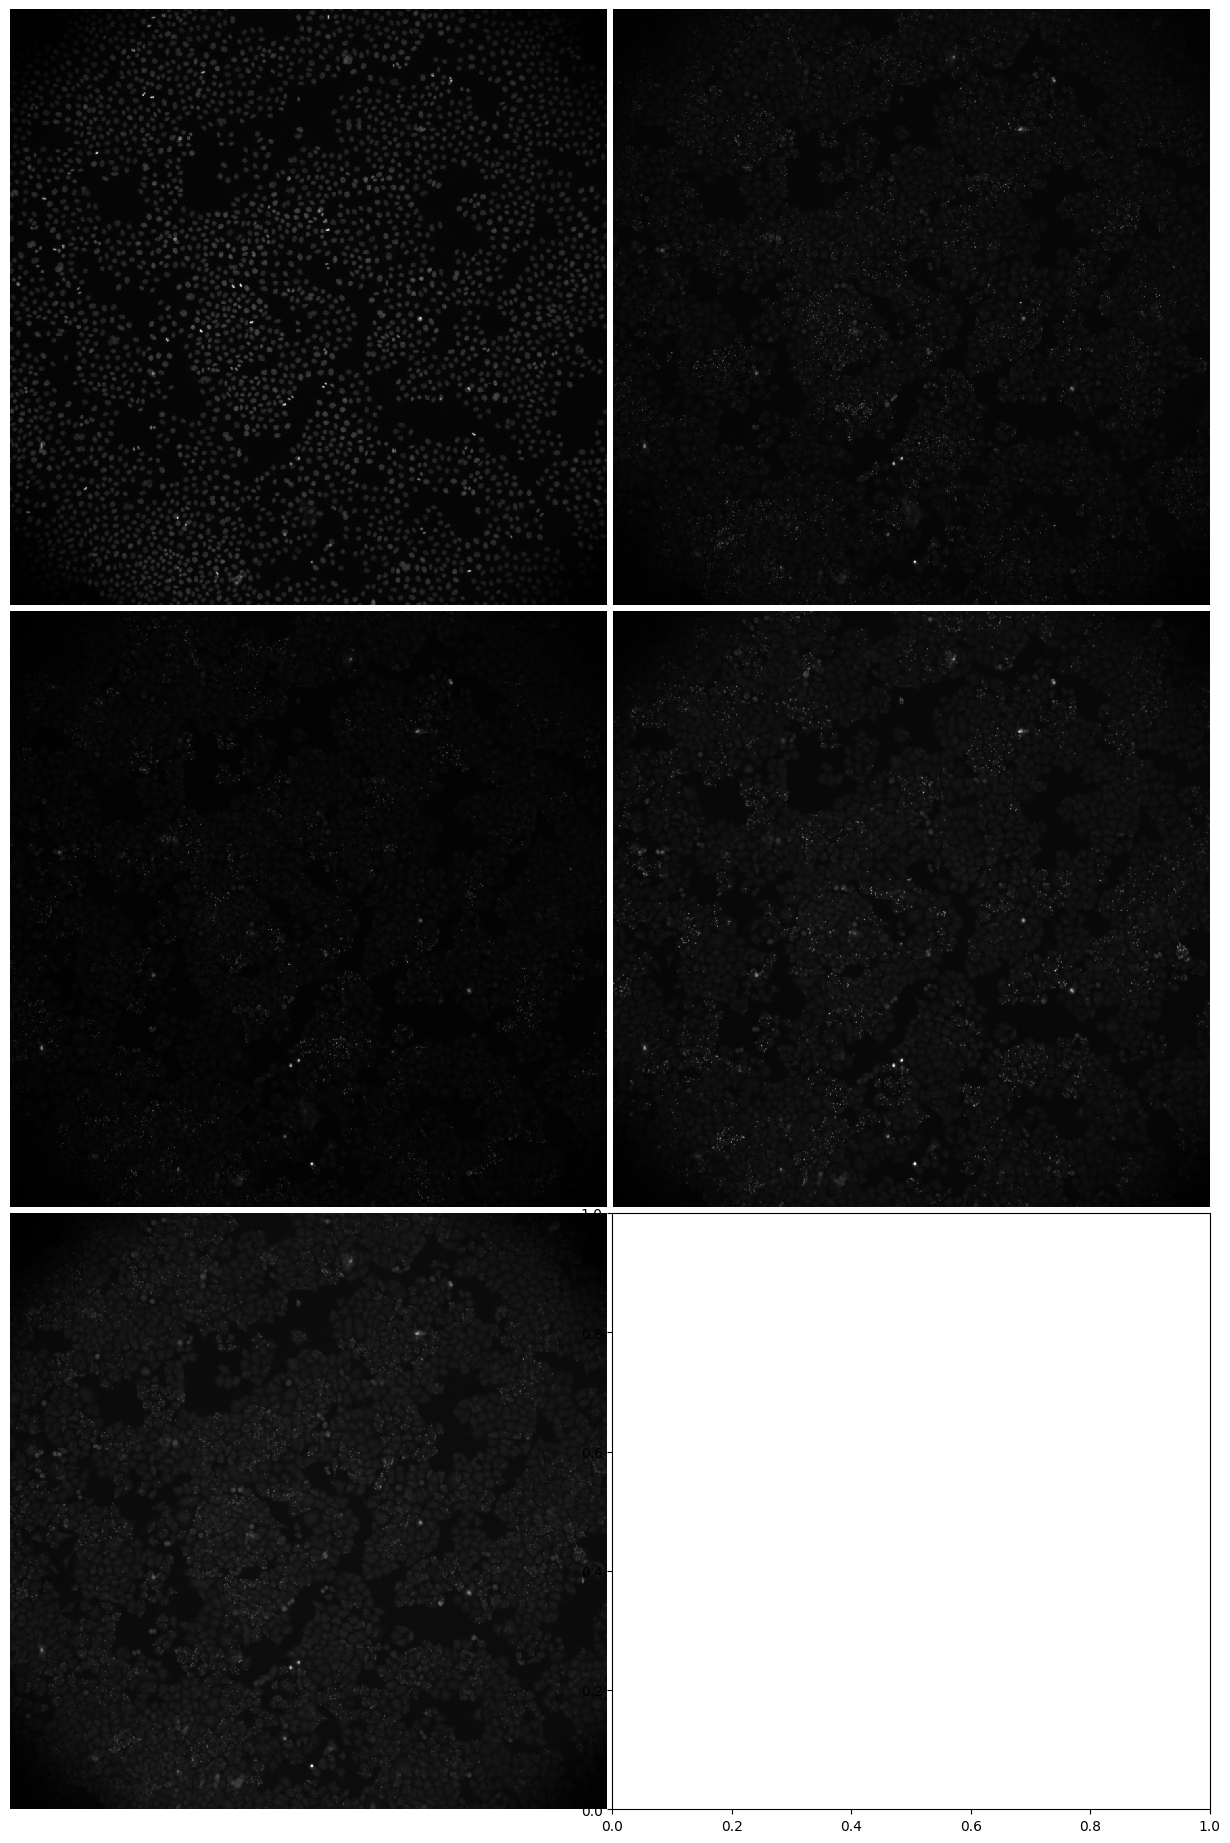

In [18]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        plate=sbs_samples["plate"][0],
        well=sbs_samples["well"][0],
        cycle=1,
        channel_order=None,
    )

    # Convert test sbs sample to tiff
    sbs_image, SBS_TILES = nd2_to_tiff_well(sbs_sample, position=0, channel_order_flip=SBS_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True)    
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()


Processing file: /archive/cheeseman/brieflow_screens/baker/input_sbs/plate_1/c2/20220701_105238_346/WellA1_ChannelCY3_30p_545_Seq0000.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)

Processing file: /archive/cheeseman/brieflow_screens/baker/input_sbs/plate_1/c2/20220701_105238_346/WellA1_ChannelA594_30p_Seq0006.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)

Processing file: /archive/cheeseman/brieflow_screens/baker/input_sbs/plate_1/c2/20220701_105238_346/WellA1_ChannelCY5_30p_Seq0012.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)

Processing file: /archive/cheeseman/brieflow_screens/baker/input_sbs/plate_1/c2/20220701_105238_346/WellA1_ChannelCY7_30p_Seq0018.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)
Final dimensions (CYX): (4, 1480, 1480)
Array size in bytes: 17523200
Conve

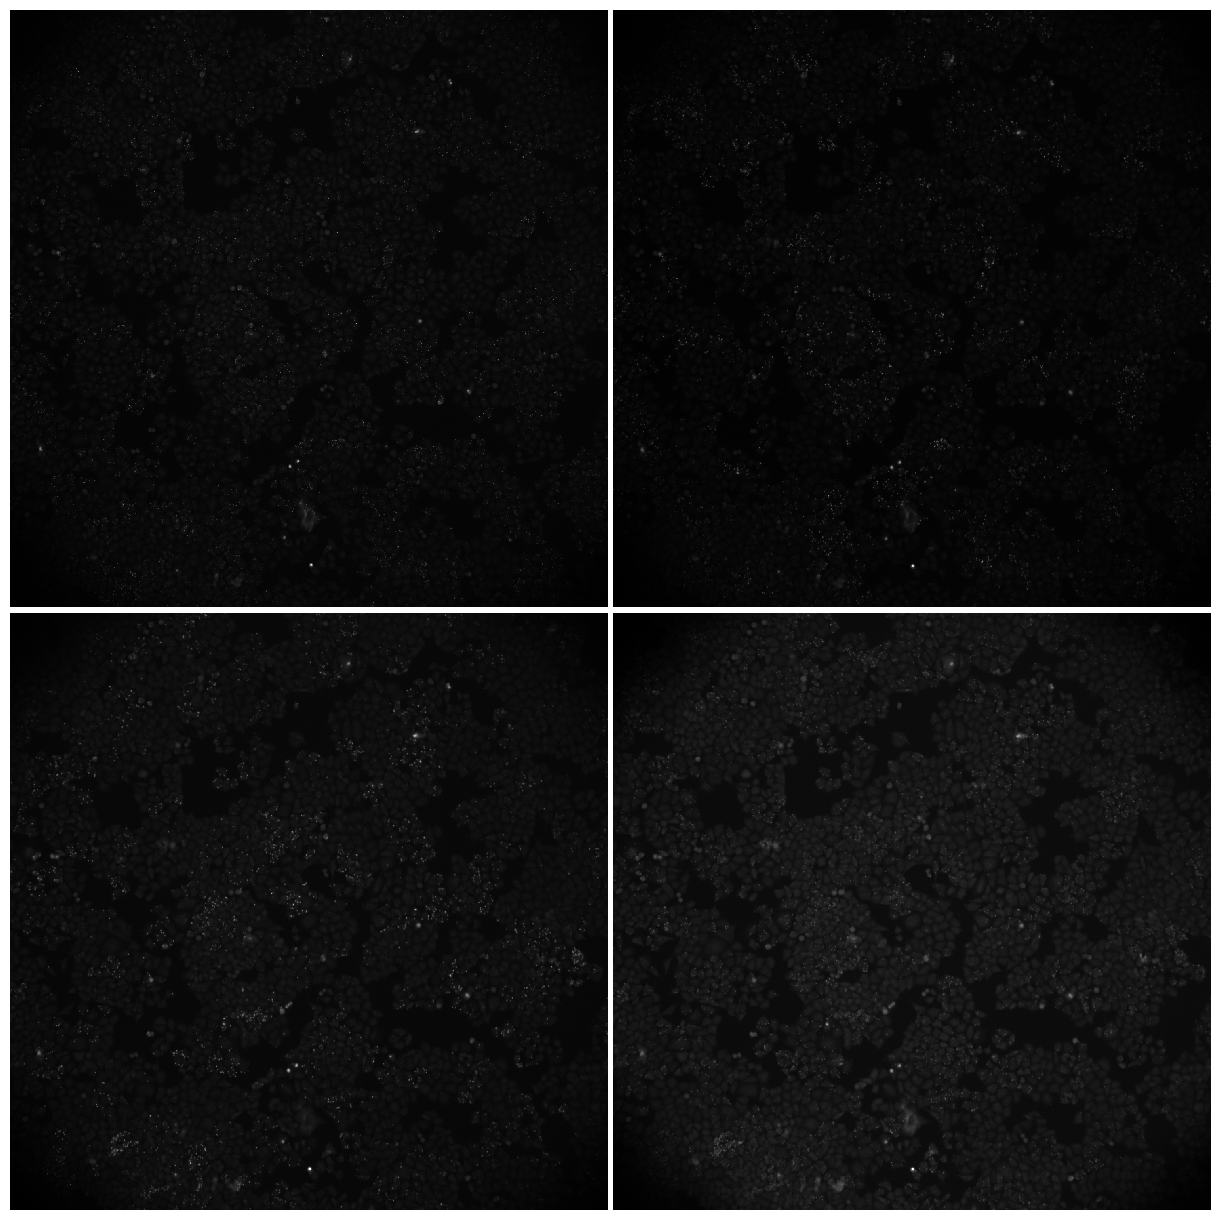

In [19]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        plate=sbs_samples["plate"][0],
        well=sbs_samples["well"][0],
        cycle=2,
        channel_order=SBS_CHANNEL_ORDER,
    )

    # Convert test sbs sample to tiff
    sbs_image, SBS_TILES = nd2_to_tiff_well(sbs_sample, position=0, channel_order_flip=SBS_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True)    
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()

### Test phenotype conversion


Processing file: /archive/cheeseman/brieflow_screens/baker/input_ph/plate_1/round_1/WellA1_ChannelDAPI_1x1_LF_Seq0003.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes




Z-stack shape: (4, 2960, 2960)
Frame shape after Z processing: (2960, 2960)

Processing file: /archive/cheeseman/brieflow_screens/baker/input_ph/plate_1/round_1/WellA1_ChannelGFP_1x1_LF_Seq0002.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes




Z-stack shape: (4, 2960, 2960)
Frame shape after Z processing: (2960, 2960)

Processing file: /archive/cheeseman/brieflow_screens/baker/input_ph/plate_1/round_1/WellA1_ChannelA594_1x1_LF_Seq0001.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes




Z-stack shape: (4, 2960, 2960)
Frame shape after Z processing: (2960, 2960)

Processing file: /archive/cheeseman/brieflow_screens/baker/input_ph/plate_1/round_1/WellA1_ChannelA750_1x1_LF_Seq0000.nd2

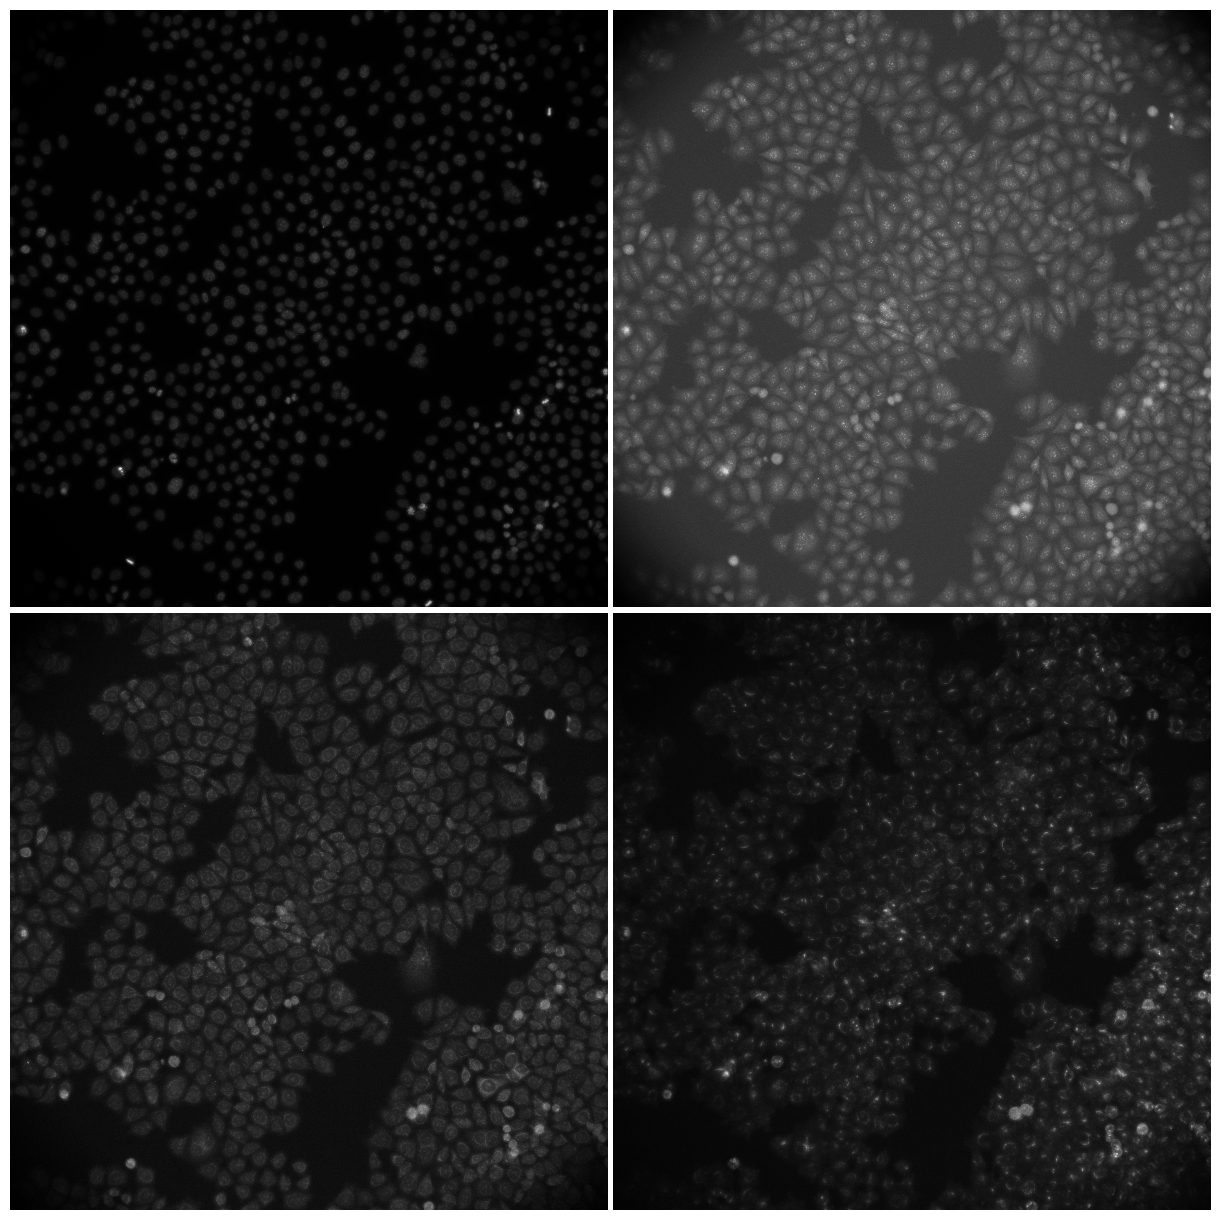

In [20]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=phenotype_samples["plate"][0],
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

## Create combo files 

In [21]:
# paths to combo dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = "config/phenotype_combo.tsv"

In [24]:
base_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
# Create a list of all tiles
tiles = [str(i) for i in range(SBS_TILES)]
# Create product of base combos and tiles
sbs_wildcard_combos = pd.DataFrame([
    {**row.to_dict(), "tile": tile}
    for _, row in base_combos.iterrows()
    for tile in tiles
])
sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
print("SBS wildcard combos:")
display(sbs_wildcard_combos)

base_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
# Create a list of all tiles
tiles = [str(i) for i in range(PHENOTYPE_TILES)]
# Create product of base combos and tiles
phenotype_wildcard_combos = pd.DataFrame([
    {**row.to_dict(), "tile": tile}
    for _, row in base_combos.iterrows()
    for tile in tiles
])
phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
print("Phenotype wildcard combos:")
display(phenotype_wildcard_combos)

SBS wildcard combos:


plate cycle well                                       channel tile
0         1     1   A1  Dapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    0
1         1     1   A1  Dapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    1
2         1     1   A1  Dapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    2
3         1     1   A1  Dapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    3
4         1     1   A1  Dapi_1p-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    4
...     ...   ...  ...                                           ...  ...
65929     1     9   B3                                       CY7_30p  328
65930     1     9   B3                                       CY7_30p  329
65931     1     9   B3                                       CY7_30p  330
65932     1     9   B3                                       CY7_30p  331
65933     1     9   B3                                       CY7_30p  332

[65934 rows x 5 columns]

Phenotype wildcard combos:


plate round well   channel  tile
0         1     1   A1  A594_1x1     0
1         1     1   A1  A594_1x1     1
2         1     1   A1  A594_1x1     2
3         1     1   A1  A594_1x1     3
4         1     1   A1  A594_1x1     4
...     ...   ...  ...       ...   ...
30739     1     1   B3   GFP_1x1  1276
30740     1     1   B3   GFP_1x1  1277
30741     1     1   B3   GFP_1x1  1278
30742     1     1   B3   GFP_1x1  1279
30743     1     1   B3   GFP_1x1  1280

[30744 rows x 5 columns]

## <font color='red'>SET PARAMETERS</font>

### Calculate illumination correction field

- `SAMPLE_FRACTION`: Controls what percentage of images to use when calculating the illumination correction field (0.0-1.0). Using a smaller fraction (e.g., 0.2 = 20%) speeds up processing by randomly sampling only a subset of your images. Default is 1.0 (use all images). For reliable results, ensure your sample contains enough images to accurately represent illumination variation.

In [25]:
SAMPLE_FRACTION = 0.5

## Create config file with params

In [26]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
    "sample_fraction": SAMPLE_FRACTION,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)